# Preamble

In [1]:
import meep as mp
import meep.materials as mats
from meep import mpb
import meeputils as mu
from wurlitzer import pipes, STDOUT
from io import StringIO
from scipy.interpolate import RectBivariateSpline

# Definitions

In [2]:
# get_wgparams:  Solves at some wavelength lam with size W, H, h, etc.
def get_wgparams(W, H, h, lam, do_func=None, solver=None):
    # if not (solver is None):
    #     ms = solver
    # Set up geometry.
    nSi = mu.get_index('Si', lam); ngSi = mu.get_ng('Si', lam)
    nSiO2 = mu.get_index('SiO2', lam); ngSiO2 = mu.get_ng('SiO2', lam)
    Si = mp.Medium(index=nSi); SiO2 = mp.Medium(index=nSiO2)

    ms = mpb.ModeSolver(geometry_lattice=lat,
                        geometry=[],
                        k_points=k_points,
                        resolution=res,
                        num_bands=n_bands,
                        default_material=SiO2)

    geom = [#mp.Block(size=mp.Vector3(mp.inf, mp.inf, -Wgrid/2), center=mp.Vector3(0, 0, -Wgrid/4), material=SiO2),
            mp.Block(size=mp.Vector3(mp.inf, W, H), material=Si),
            mp.Block(size=mp.Vector3(mp.inf, mp.inf, h), center=mp.Vector3(0, 0, -(H-h)/2), material=Si)]
    ms.geometry = geom
    ms.default_material = SiO2

    blackhole = StringIO()
    with pipes(stdout=blackhole, stderr=STDOUT):
        ms.init_params(mp.NO_PARITY, False)
        eps = np.array(ms.get_epsilon())
    isSi = (eps - nSiO2 ** 2) / (nSi ** 2 - nSiO2 ** 2)

    out = {}

    def get_fieldprops(ms, band):
        if (out != {}):
            return
        e = np.array(ms.get_efield(band))
        eps_ei2 = eps.reshape(eps.shape+(1,)) * np.abs(e[:, :, 0, :]**2)
        ei_pwr = eps_ei2.sum(axis=(0, 1))
        if (ei_pwr[1] > ei_pwr[2]):
            print ("TE mode!\n")
            # Calculate eps |E|^2.  Then get power in the silicon, and distribution along x.
            # Get n_g.  Adjust by material disperision factor (n_{g,mat}/n_{mat}), weighted by eps |E|^2 above.
            epwr = eps_ei2.sum(-1) / eps_ei2.sum()
            pSi_x = (epwr * isSi).sum(-1)
            pSi = pSi_x.sum()
            pSi_strip = (pSi_x * (np.abs(np.linspace(-Wgrid/2, Wgrid/2, len(pSi_x))) <= W/2)).sum()
            ng_nodisp = 1 / ms.compute_one_group_velocity_component(mp.Vector3(1, 0, 0), band)
            ng = ng_nodisp * (pSi * (ngSi / nSi) + (1 - pSi) * (ngSiO2 / nSiO2))

            # Output various stuff.
            out['band'] = band
            out['ng'] = ng
            out['pSi'] = pSi
            out['pSi_x'] = pSi_x #np.array(pSi_x[len(pSi_x)//2:] * 2)
            out['pSi_strip'] = pSi_strip

            if (do_func != None):
                do_func(out, ms, band)

    with pipes(stdout=blackhole, stderr=STDOUT):
        k = ms.find_k(mp.NO_PARITY,
                      1/lam,
                      1, 1,
                      mp.Vector3(1, 0, 0),
                      1e-4,
                      (nSiO2+nSi)/(2*lam), nSiO2/lam, nSi/lam,
                      get_fieldprops)

    if (out == {}):
        print ("TE mode not found.")
        return out

    out['neff'] = k[out['band']-1] / (1 / lam)

    print ("lam = {:.2f}, W = {:.2f}, H = {:.2f}, h = {:.2f}, neff = {:.3f}, ng = {:.3f}, "
           "pSi = {:.2f}, pStrip = {:.2f}".format(lam, W, H, h, out['neff'], out['ng'], out['pSi'], out['pSi_strip']))
    return out

# interp_grid:   Interpolates a coarse grid to a fine one (useful for nice contour plotting)
def interp_grid(z, fact=2):
    (nx, ny) = z.shape
    (x1, y1) = (np.linspace(0, 1, nx), np.linspace(0, 1, ny))
    (x2, y2) = (np.linspace(0, 1, (nx - 1) * fact + 1), np.linspace(0, 1, (ny - 1) * fact + 1))
    sp = RectBivariateSpline(x1, y1, z, kx=1, ky=1)
    return sp(x2, y2)



In [3]:
Wlist = np.linspace(0.4, 1.0, 25) 
Hlist = np.linspace(0.2, 0.7, 21) 
hlist = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
lamList = np.array([1.2, 1.3, 1.4, 1.55, 1.8, 2.0])

(Wgrid, Hgrid) = (2, 2)


n_points = 32
n_bands  = 4
res      = 128
k_points = mp.interpolate(n_points, [mp.Vector3(0.05, 0, 0), mp.Vector3(0.05*n_points, 0, 0)])

lat = mp.Lattice(size=mp.Vector3(0, Wgrid, Hgrid))

In [6]:
W = 0.5
H = 0.2
h = 0.05
lam = 0.5

do_func = None

nAlOx = mu.get_index('Alumina', lam)
ngAlOx = mu.get_ng('Alumina', lam)
nSiO2 = mu.get_index('SiO2', lam)
ngSiO2 = mu.get_ng('SiO2', lam)

AlOx = mp.Medium(index=nAlOx)
SiO2 = mp.Medium(index=nSiO2)
Air = mp.Medium(index=1)

ms = mpb.ModeSolver(geometry_lattice=lat,
                    geometry=[],
                    k_points=k_points,
                    resolution=res,
                    num_bands=n_bands,
                    default_material=SiO2)

geom = [#mp.Block(size=mp.Vector3(mp.inf, mp.inf, -Wgrid/2), center=mp.Vector3(0, 0, -Wgrid/4), material=SiO2),
        mp.Block(size=mp.Vector3(mp.inf, W, H), material=AlOx),
        mp.Block(size=mp.Vector3(mp.inf, mp.inf, h), center=mp.Vector3(0, 0, -(H-h)/2), material=AlOx)]
ms.geometry = geom
ms.default_material = SiO2

blackhole = StringIO()
with pipes(stdout=blackhole, stderr=STDOUT):
    ms.init_params(mp.NO_PARITY, False)
    eps = np.array(ms.get_epsilon())
isAlOx = (eps - nSiO2 ** 2) / (nAlOx ** 2 - nSiO2 ** 2)

out = {}

def get_fieldprops(ms, band):
    if (out != {}):
        return
    e = np.array(ms.get_efield(band))
    eps_ei2 = eps.reshape(eps.shape+(1,)) * np.abs(e[:, :, 0, :]**2)
    ei_pwr = eps_ei2.sum(axis=(0, 1))
    if (ei_pwr[1] > ei_pwr[2]):
        print ("TE mode!\n")
        # Calculate eps |E|^2.  Then get power in the silicon, and distribution along x.
        # Get n_g.  Adjust by material disperision factor (n_{g,mat}/n_{mat}), weighted by eps |E|^2 above.
        epwr = eps_ei2.sum(-1) / eps_ei2.sum()
        pAlOx_x = (epwr * isAlOx).sum(-1)
        pAlOx = pAlOx_x.sum()
        pAlOx_strip = (pAlOx_x * (np.abs(np.linspace(-Wgrid/2, Wgrid/2, len(pAlOx_x))) <= W/2)).sum()
        ng_nodisp = 1 / ms.compute_one_group_velocity_component(mp.Vector3(1, 0, 0), band)
        ng = ng_nodisp * (pAlOx * (ngAlOx / nAlOx) + (1 - pAlOx) * (ngSiO2 / nSiO2))

        # Output various stuff.
        out['band'] = band
        out['ng'] = ng
        out['pAlOx'] = pAlOx
        out['pAlOx_x'] = pAlOx_x #np.array(pSi_x[len(pSi_x)//2:] * 2)
        out['pAlOx_strip'] = pAlOx_strip

        if (do_func != None):
            do_func(out, ms, band)

with pipes(stdout=blackhole, stderr=STDOUT):
    k = ms.find_k(mp.NO_PARITY,
                  1/lam,
                  1, 1,
                  mp.Vector3(1, 0, 0),
                  1e-4,
                  (nSiO2+nAlOx)/(2*lam),
                  nSiO2/lam,
                  nAlOx/lam,
                  get_fieldprops)

# if (out == {}):
#     print ("TE mode not found.")
#     return out

out['neff'] = k[out['band']-1] / (1 / lam)

print ("lam = {:.2f}, W = {:.2f}, H = {:.2f}, h = {:.2f}, neff = {:.3f}, ng = {:.3f}, "
       "pAlOx = {:.2f}, pStrip = {:.2f}".format(lam, W, H, h, out['neff'], out['ng'], out['pAlOx'], out['pAlOx_strip']))

band = 1
e = np.array(ms.get_efield(band))
eps_ei2 = eps.reshape(eps.shape+(1,)) * np.abs(e[:, :, 0, :]**2)
ei_pwr = eps_ei2.sum(axis=(0, 1))

if (ei_pwr[1] > ei_pwr[2]):
    print ("TE mode!\n")
    # Calculate eps |E|^2.  Then get power in the silicon, and distribution along x.
    # Get n_g.  Adjust by material disperision factor (n_{g,mat}/n_{mat}), weighted by eps |E|^2 above.
    epwr = eps_ei2.sum(-1) / eps_ei2.sum()
    pAlOx_x = (epwr * isAlOx).sum(-1)
    pAlOx = pAlOx_x.sum()
    pAlOx_strip = (pAlOx_x * (np.abs(np.linspace(-Wgrid/2, Wgrid/2, len(pAlOx_x))) <= W/2)).sum()
    ng_nodisp = 1 / ms.compute_one_group_velocity_component(mp.Vector3(1, 0, 0), band)
    ng = ng_nodisp * (pAlOx * (ngAlOx / nAlOx) + (1 - pAlOx) * (ngSiO2 / nSiO2))

    # Output various stuff.
    out['band'] = band
    out['ng'] = ng
    out['pAlOx'] = pAlOx
    out['pAlOx_x'] = pAlOx_x #np.array(pSi_x[len(pSi_x)//2:] * 2)
    out['pAlOx_strip'] = pAlOx_strip

Working in 3 dimensions.
Grid size is 1 x 256 x 256.
Solving for 4 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 2, 0)
     (0, 0, 2)
Cell volume = 4
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 0.5, -0)
     (0, -0, 0.5)
Geometric objects:
     block, center = (0,0,0)
          size (1e+20,0.5,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-0.075)
          size (1e+20,1e+20,0.05)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 4 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: .
Initializing fields to random numbers...
epsilon: 2.13827-2.7026, mean 2.16296, harm. mean 2.15814, 100% > 1, 4.37525% "fill"
Initializing fields to random numbers...
Initializing eigensolver data
Computing 1 bands with 1e-07 tolerance
Working in 3 dimensions.
Grid size is 1 x 256 x 256.
Solving for 1 bands at a t

In [7]:
nx = eps.shape[0]
ny = eps.shape[1]
x = Wgrid * np.linspace(-1/2., 1/2., nx)
y = Hgrid * np.linspace(-1/2., 1/2., ny)

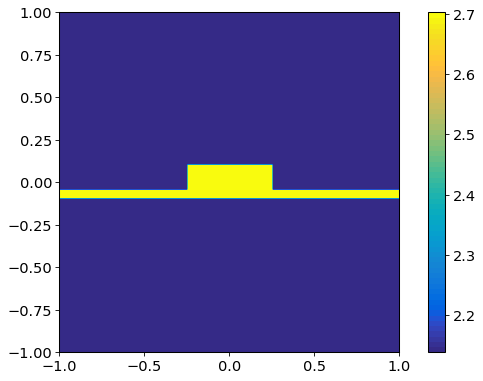

In [8]:
p = plt.pcolormesh(x,y,eps.T)
ax = plt.gca()
ax.set_aspect('equal')
plt.colorbar(p)

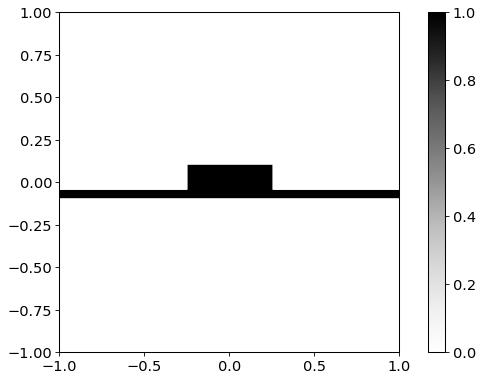

In [9]:
p = plt.pcolormesh(x,y,isAlOx.T,cmap=cm.Greys)
ax = plt.gca()
ax.set_aspect('equal')
plt.colorbar(p)

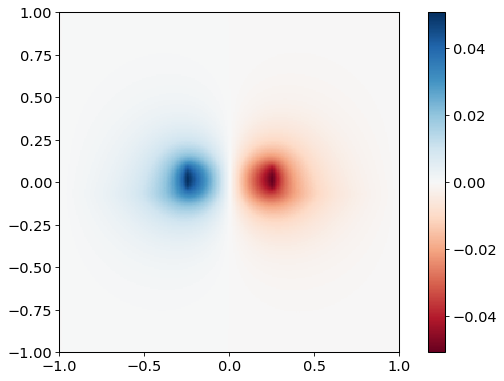

In [14]:
axind = 0
p = plt.pcolormesh(x,y,e[:,:,0,axind].T.real,cmap=cm.RdBu)
ax = plt.gca()
ax.set_aspect('equal')
plt.colorbar(p)

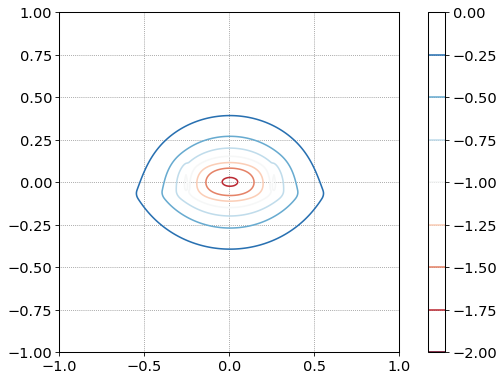

In [28]:
axind = 1
# p = plt.pcolormesh(x,y,e[:,:,0,axind].T.real,cmap=cm.RdBu)
p= plt.contour(x,y,e[:,:,0,axind].T.real,cmap=cm.RdBu)
ax = plt.gca()
ax.set_aspect('equal')
plt.colorbar(p)

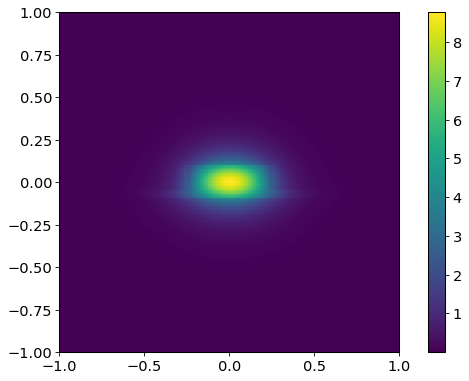

In [31]:
axind = 1
p = plt.pcolormesh(x,y,eps_ei2[:,:,axind].T,cmap=cm.viridis)
ax = plt.gca()
ax.set_aspect('equal')
plt.colorbar(p)

In [10]:
out.keys()

dict_keys(['band', 'ng', 'pAlOx', 'pAlOx_x', 'pAlOx_strip', 'neff'])

In [13]:
e.shape

(256, 256, 1, 3)

In [19]:
#ei_pwr = eps_ei2.sum(axis=(0, 1))
ei_pwr[1]

16034.268417548254

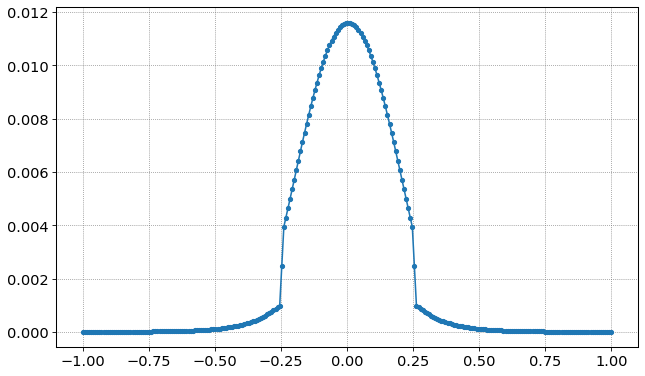

In [23]:
plt.plot(x,out['pAlOx_x'],'.-')

In [30]:
eps_ei2.shape

(256, 256, 3)